In [39]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
from sklearn.preprocessing import LabelEncoder


In [40]:
detector = MTCNN()


# Automate the preprocessing

In [41]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                print("error for face extraction for file "+im_name)
                print(e)
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)} for person {sub_dir}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(16,12))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

Loaded successfully: 5 for person anna
Loaded successfully: 7 for person aswin
Loaded successfully: 5 for person tiffany
Loaded successfully: 5 for person tom cruise
Loaded successfully: 5 for person vijay sethupathi


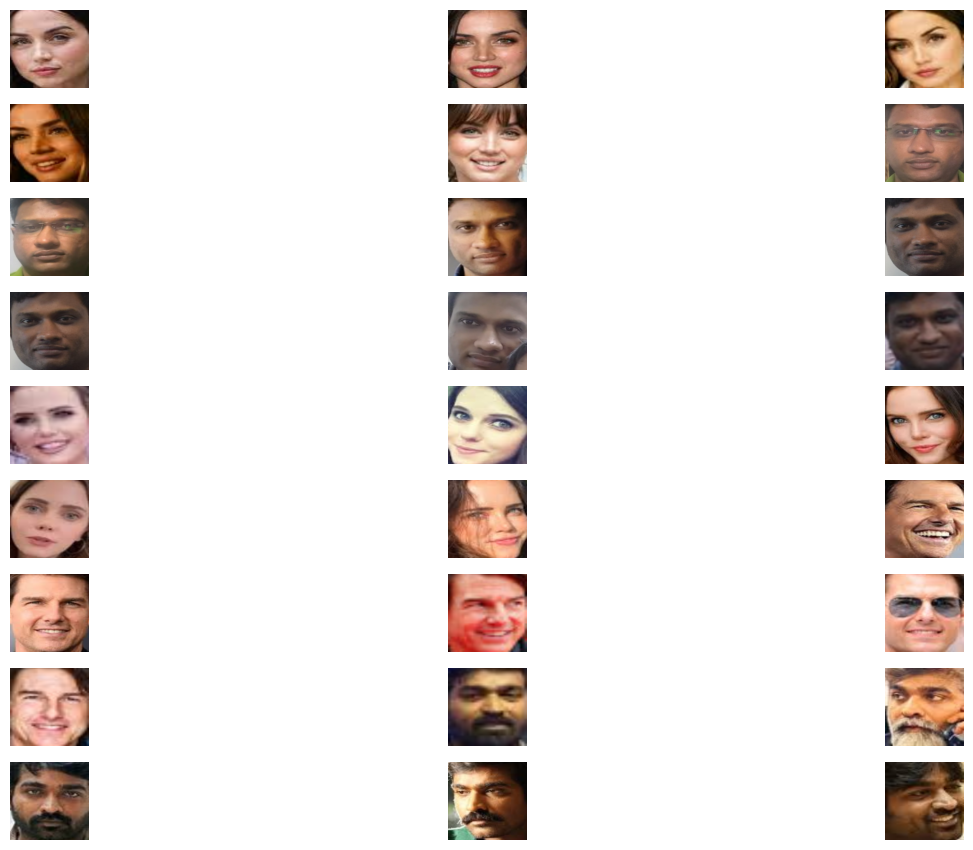

In [42]:
#crop faces from training images
faceloading = FACELOADING("./training")
X, Y = faceloading.load_classes()
faceloading.plot_images()

# Feature Extraction

In [43]:
#Facenet library for feature extraction
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

EMBEDDED_X = []
detected_faces = X
for img in detected_faces:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)
np.savez_compressed('.\\embeddings\\faces_embeddings.npz', EMBEDDED_X, Y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

## Label Encoding

In [44]:
encoder = LabelEncoder()
encoder.fit(Y)
#encode person names
Y = encoder.transform(Y)

## Train SVM classifier

In [45]:

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

## validate model

In [46]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, ypreds_test)

1.0

## save the model

In [47]:
import pickle
with open('svm_model.pkl','wb') as f:
    pickle.dump(model,f)

# Face Identification program

In [48]:
import cv2 as cv
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN

In [49]:
#INITIALIZE
facenet = FaceNet()
faces_embeddings = np.load(".\\embeddings\\face_embeddings.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
model = pickle.load(open("svm_model.pkl", 'rb'))

In [50]:
def get_embedding(face_img):
    embedder = FaceNet()
    face_img = face_img.astype('float32')  # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat = embedder.embeddings(face_img)
    return yhat[0]  # 512D image (1x1x512)


def recognize_image(image_path, image_name):
    im = cv.imread(image_path)
    if im is None:
        print("File Not Found")
    else:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        detector = MTCNN()
        x, y, w, h = detector.detect_faces(im)[0]['box']
        face = im[y:y + h, x:x + w]
        face = cv.resize(im, (160, 160))
        face_embedding = get_embedding(face)
        face_embedding = [face_embedding]
        ypreds = model.predict(face_embedding)
        conf_score = model.predict_proba(face_embedding)[0]
        name='unknown'
        print("Predicting image ", image_name)
        for i, value in np.ndenumerate(conf_score):
            print(f"index:{i[0]} value:{value}")
            if value > .36:
                print(f"index:{i[0]} value:{value}")
                ypreds[0] = i[0]
                name = encoder.inverse_transform(ypreds)[0]
        cv.rectangle(im, (x, y), (x + w, y + h), (255, 0, 255), 3)

        # Postion text below bounding box
        font = cv.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        font_thickness = 2
        text_color = (0, 128, 0)  # green
        # Get the size of the text to ensure it fits and for proper vertical offset
        (text_width, text_height), baseline = cv.getTextSize(name, font, font_scale, font_thickness)
        text_x = x
        text_y = y + h + text_height + 5  # 5 pixels margin below the box
        cv.putText(im, str(name), (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, cv.LINE_AA)
        plt.imshow(im)
        plt.show()
        print(name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting image  t1.jpeg
index:0 value:0.18183806905463967
index:1 value:0.1273066451904628
index:2 value:0.3933046612342001
index:2 value:0.3933046612342001
index:3 value:0.1619330888559413
index:4 value:0.1356175356647563


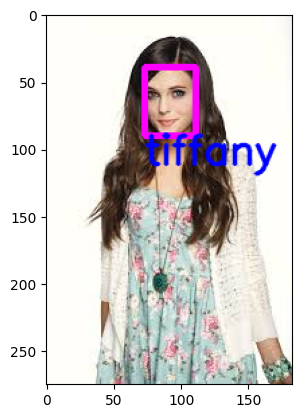

tiffany
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicting image  t2.jpeg
index:0 value:0.20096156551775626
index:1 value:0.1406511956356432
index:2 value:0.388614039395073
index:2 value:0.388614039395073
index:3 value:0.14067078888943108
index:4 value:0.12910241056209648


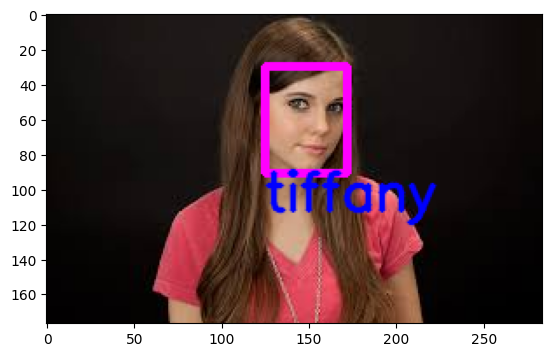

tiffany


In [51]:
def recognize_folder(folder_path):
    for file_name in os.listdir(folder_path):
        path = os.path.join(folder_path, file_name)
        recognize_image(path, file_name)



recognize_folder(os.path.join(os.getcwd(),"test images"))